# Ransac sift homography
0.	选择两幅部分内容一致，部分内容不同的图像，两者可以有角度/位移等变化。【这个变化完全可以由第一周的内容自己做出来】
1.	对两幅图像分别进行关键点检测，比如用 SIFT. 【大家完全可以尝试别的关键点】
2.	对两幅图像的关键点进行进行匹配并用 RANSAC 去噪，找到单应性关系(knn)
3.	将第二幅图像按照单应性关系进行变换 【即右乘单应性矩阵】
4.	将两幅图像相互对应的点重合，其余点也即进行融合。因旋转造成图像 size 大小不同等， 补 0 即可。

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
print(cv2.__version__)

3.4.2


In [4]:
img1 = cv2.imread('IMG_1336.jpg')
img2 = cv2.imread('IMG_1337.jpg')
img3 = cv2.imread('IMG_1338.jpg')

In [5]:
images = []
images.append(img1)
images.append(img2)
images.append(img3)

In [52]:
def my_show(img):
    plt.figure(figsize=(10,10),dpi=100)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

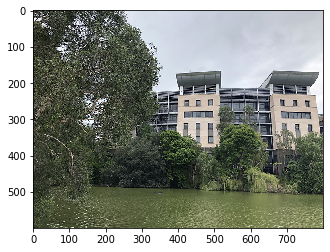

In [7]:
my_show(img1)

## SIFT

In [8]:
sift = cv2.xfeatures2d.SIFT_create()

In [9]:
def key_points(img, sift):
    kp = sift.detect(img)
    kp, des = sift.compute(img, kp)
    return kp, des


In [10]:
kp1, des1 = key_points(img1, sift)
print(des1.shape)

(3104, 128)


In [11]:
def show_key_points(img, kp):
    img_sift = cv2.drawKeypoints(img, kp, outImage=np.array([]),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(10,10),dpi=100)
    my_show(img_sift)

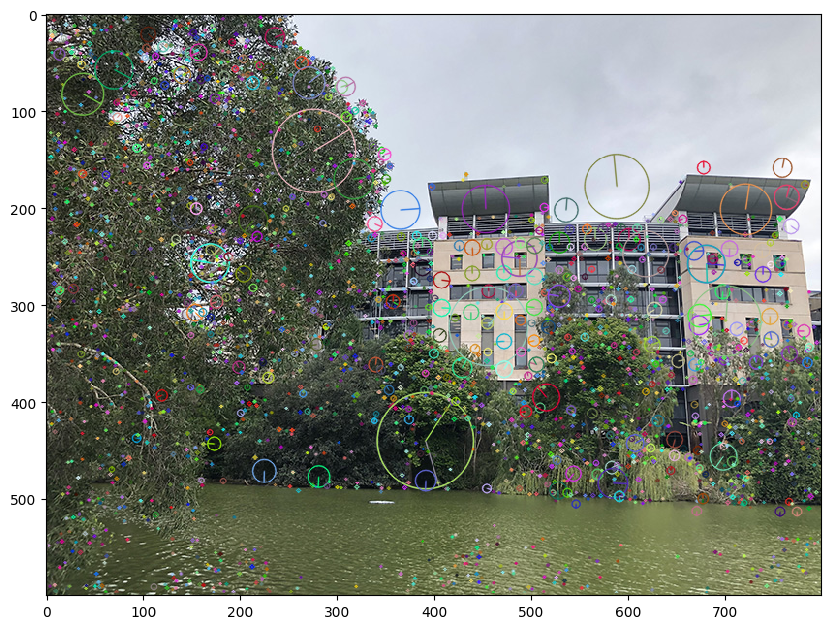

In [12]:
show_key_points(img1, kp1)

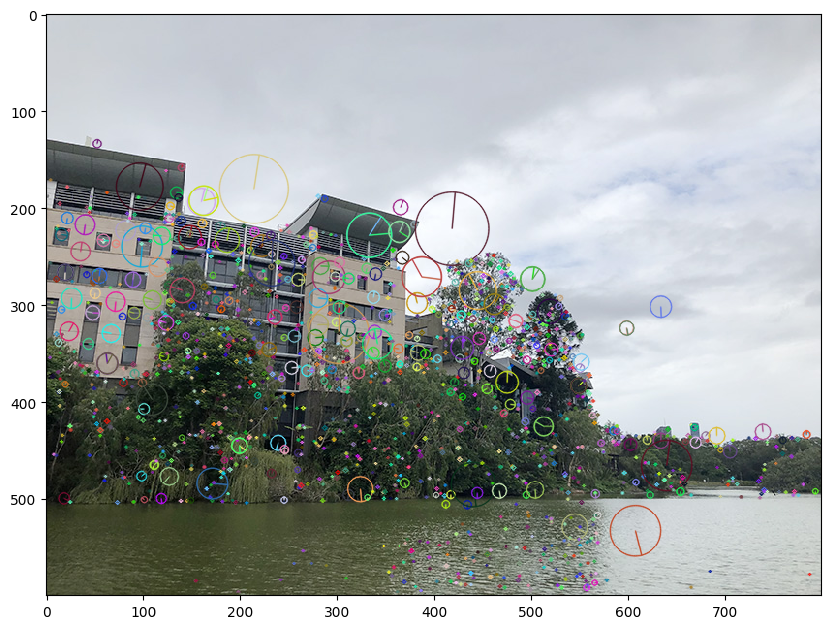

In [13]:
kp2, des2 = key_points(img2, sift)
show_key_points(img2,kp2)

## OpenCV自带的Stitch方法

In [14]:
stitcher = cv2.createStitcher()

In [15]:
(status, stitched) = stitcher.stitch(images)

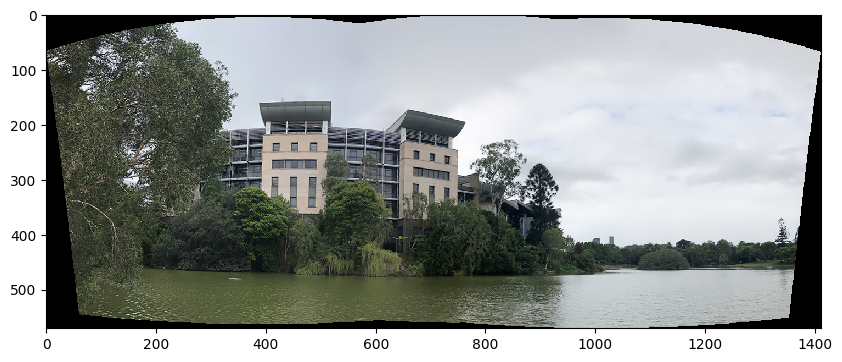

In [53]:
my_show(stitched)

## 手动实现

In [34]:
kp1, des1 = key_points(img1, sift)
kp2, des2 = key_points(img2, sift)

In [21]:
matcher = cv2.BFMatcher()
raw_matches = matcher.knnMatch(des1, des2, k=2)

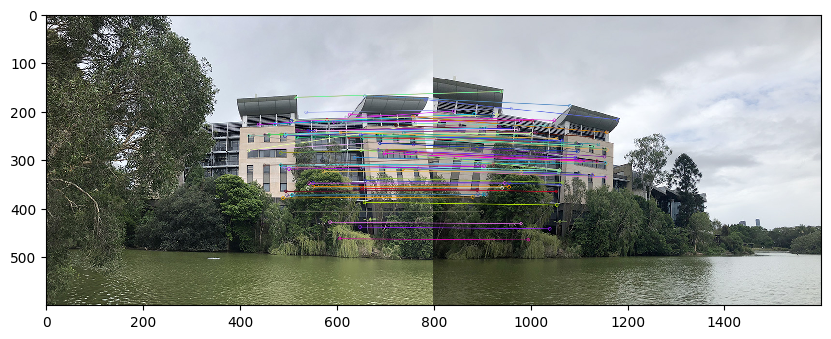

In [54]:
bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img_match = cv2.drawMatches(img1,kp1,img2,kp2,matches[:100],None, flags=2)

my_show(img_match)

In [43]:
ratio=0.85
min_match=10
smoothing_window_size=800

In [44]:
good_points = []
good_matches=[]

for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
if len(good_points) > min_match:
    image1_kp = np.float32(
        [kp1[i].pt for (_, i) in good_points])
    image2_kp = np.float32(
        [kp2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)

In [45]:
def create_mask(img1,img2,version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 +width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

In [49]:
height_img1 = img1.shape[0]
width_img1 = img1.shape[1]
width_img2 = img2.shape[1]
height_panorama = height_img1
width_panorama = width_img1 +width_img2

panorama1 = np.zeros((height_panorama, width_panorama, 3))
mask1 = create_mask(img1,img2,version='left_image')
panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
panorama1 *= mask1
mask2 = create_mask(img1,img2,version='right_image')
panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
result=panorama1+panorama2

rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]
final_result = np.array(final_result).astype("uint8")

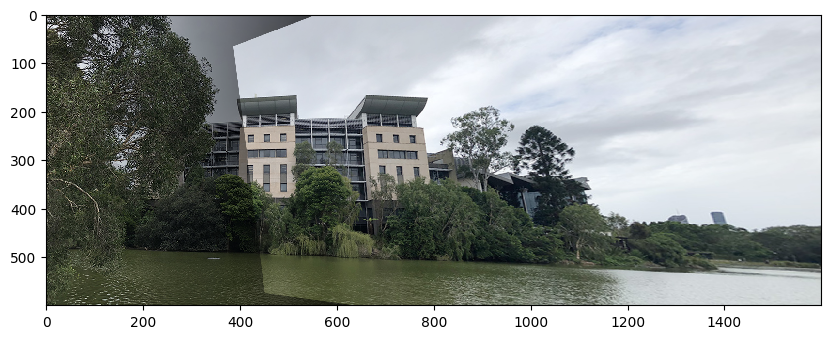

In [55]:
my_show(final_result)